# Quantified Sleep: Imputation

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
DATADIR = Path('../Data/')
FIGSDIR = Path('../Figs/')

# Load the unified dataset
df_unified = pd.read_csv(DATADIR/'Unified'/'unified_dataset.csv')
df_unified.shape

(789, 311)

## Handling Missing Data

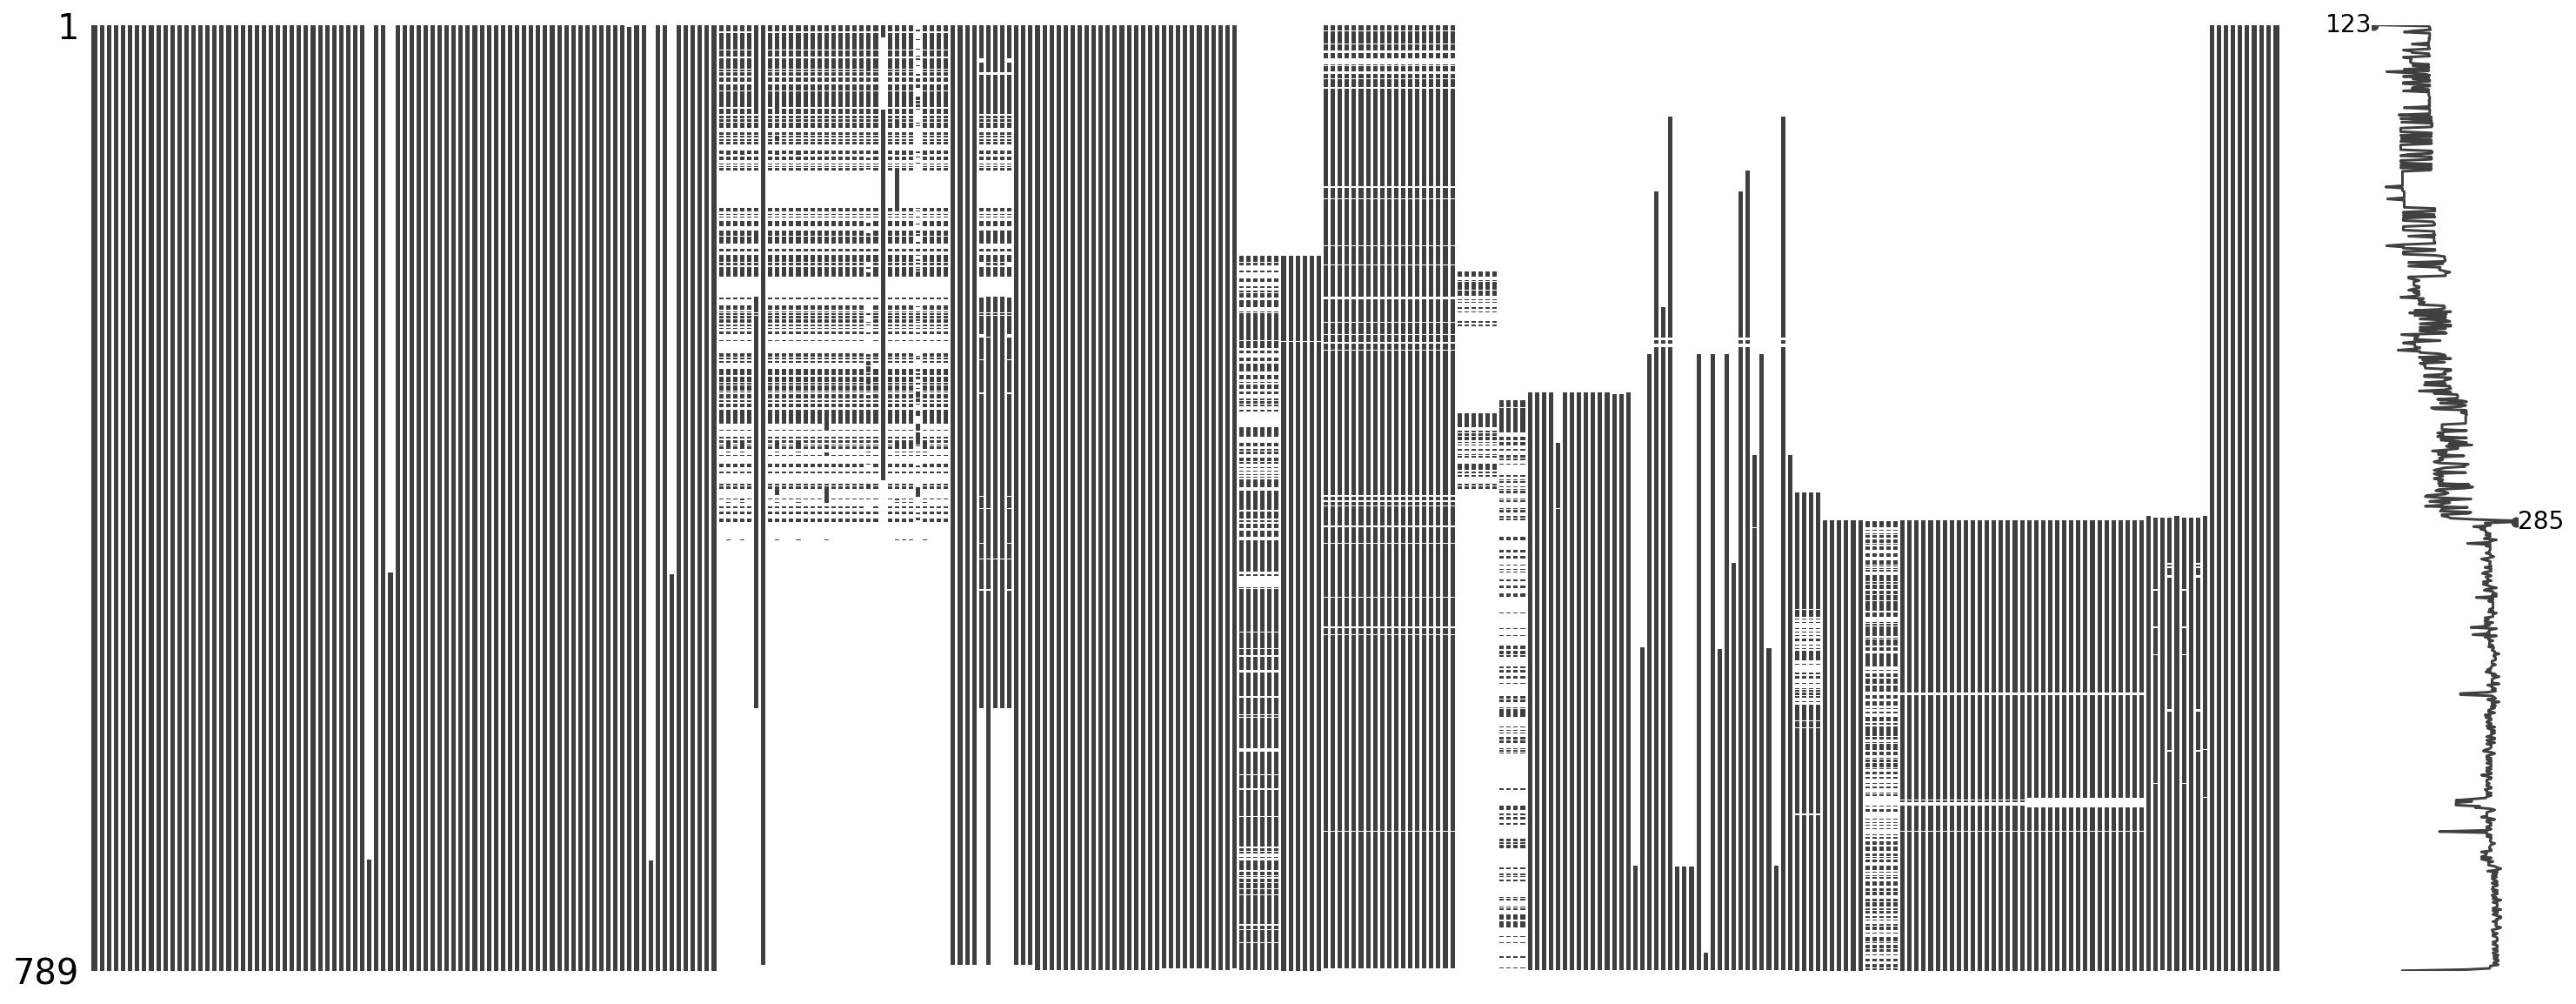

In [4]:
import missingno as msno

msno.matrix(df_unified)
plt.savefig(FIGSDIR/'03b_missing_data_matrix_original.eps')
plt.show()

I know my tracking methodology, so for _some_ missing data I can just plug in a value. For instance, I know that since I started tracking alcohol and caffeine, I never missed anything. So days with no data can be safely filled with `0`. If I didn't record it, it didn't happen. 

The engineered features that involve some _hour_ of the day are a problem. On days when I didn't drink, what do I fill in for the missing values for the hour of my first and last drink? If I fill a `0`, then that's communicating that I had a drink at midnight, which I didn't. Though, midnight wrapping should generally equate that to `24` instead of `0`.  

It seems like a reasonable value to fill here might be `-1`.

In [5]:
df_unified.fillna({
    'cbd_drops': 0.0, 
    'cbd_est_cbd_mg': 0.0,
    'melatonin_quantity': 0.0,
    'melatonin_hour_delta': -1.0,
    'melatonin_hour_taken': -1.0,
    'cbd_hour_delta': -1.0,
    'cbd_hour_taken': -1.0,
}, inplace=True)

In [6]:
# Fill rescuetime missing values with zeros (no activity logged)
rescue_cols = [c for c in df_unified.columns if 'escue' in c]
df_unified[rescue_cols] = df_unified[rescue_cols].fillna(value=0.0)

In [7]:
df_unified[rescue_cols].isna().mean()

rescue_business                  0.0
rescue_coms_and_scheduling       0.0
rescue_date                      0.0
rescue_design                    0.0
rescue_distracting               0.0
rescue_entertainment             0.0
rescue_neutral                   0.0
rescue_news                      0.0
rescue_productive                0.0
rescue_reference_and_learning    0.0
rescue_shopping                  0.0
rescue_social_network            0.0
rescue_software_dev              0.0
rescue_total_distracting_time    0.0
rescue_total_productice_time     0.0
rescue_total_time                0.0
rescue_utilities                 0.0
rescue_very_distracting          0.0
rescue_very_productice           0.0
dtype: float64

Some things I only started tracking after a certain date, but then tracked deligently (e.g. caffeine and alcohol).

In [8]:
NOMIE_START = '2019-06-09'
ZERO_START = '2019-10-05'
AWARE_START = '2020-01-14'

In [9]:
df_unified = df_unified[df_unified['oura_summary_date'] >= NOMIE_START].fillna({
    'nomie_alc_net_hour_spread': -1.0, 
    'nomie_alc_net_hour_range': -1.0,
    'nomie_alc_net_hour_max': -1.0,
    'nomie_alc_net_hour_min': -1.0,
    'nomie_caf_net_hour_spread': -1.0, 
    'nomie_caf_net_hour_range': -1.0,
    'nomie_caf_net_hour_max': -1.0,
    'nomie_caf_net_hour_min': -1.0,
    'nomie_alc_value_sum': 0.0,
    'nomie_caf_value_sum': 0.0,
})

In [10]:
# Analyse completeness by data type of column (feature)
completes = df_unified.isnull().apply(
        lambda x: 1 - np.mean(x)).reset_index().rename({'index':'field', 0: 'completeness'}, axis=1)

types = df_unified.dtypes.reset_index().rename({'index':'field', 0: 'datatype'}, axis=1)

df_com = types.merge(completes, how='left', on='field').set_index('field')
df_com['datatype'] = df_com['datatype'].apply(lambda x: str(x))
df_com.groupby('datatype').mean().sort_values(by='completeness')

,completeness
datatype,
float64,0.750007
object,0.751678
int64,1.000000


In [ ]:
# Find the least-complete columns
df_com[df_com['datatype'].isin(['int64', 'float64'])].sort_values(by='completeness').head(20)

In [12]:
# Convert some stragler categoricals to datetime
df_unified['daily_date'] = pd.to_datetime(df_unified['daily_date'])
df_unified['hk_day'] = pd.to_datetime(df_unified['hk_day'])

Let's see how the cleanup has helped with missing data

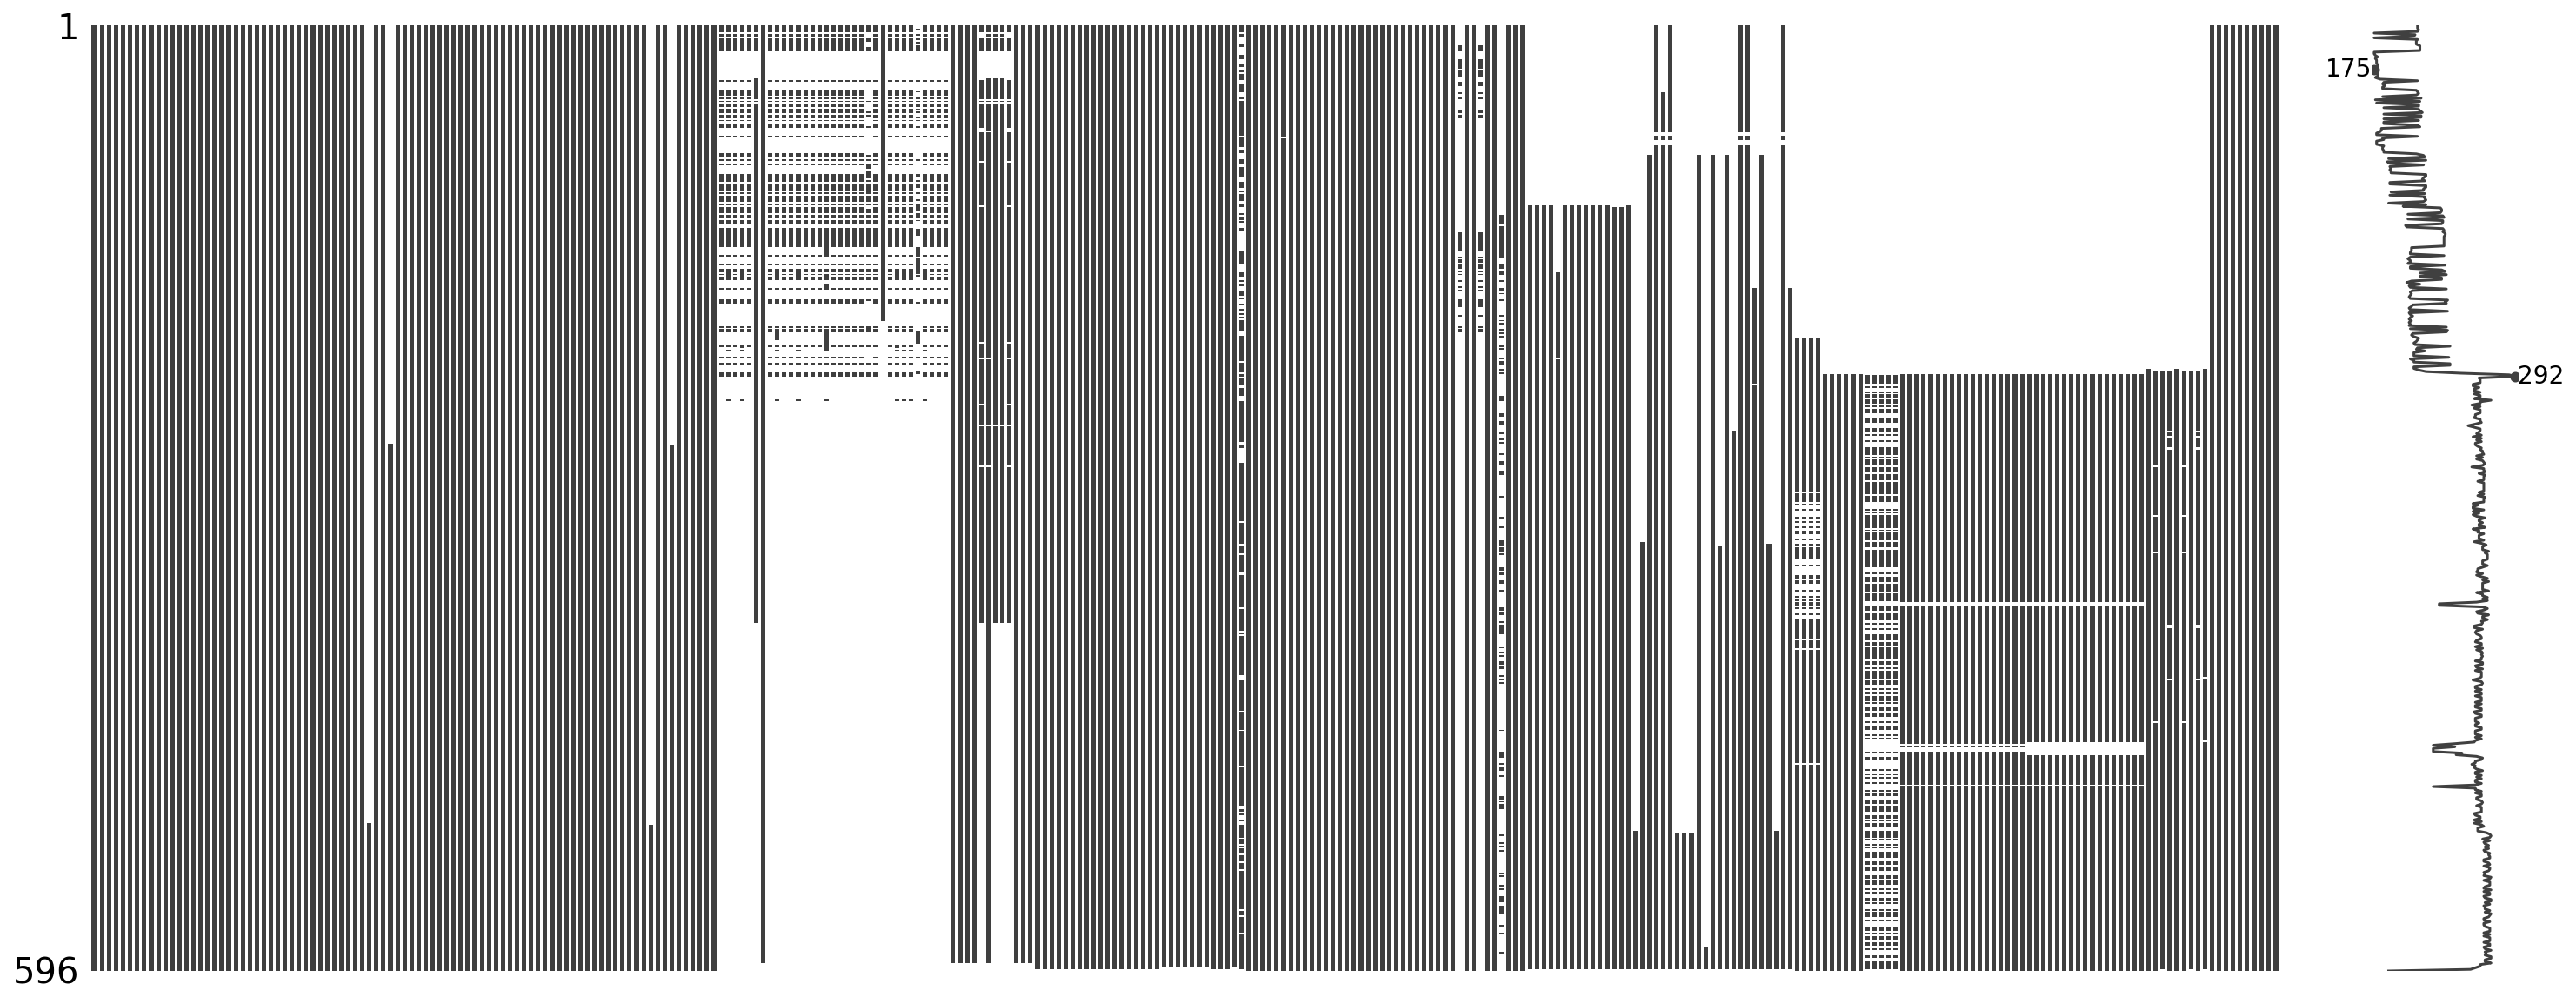

In [13]:
msno.matrix(df_unified)
plt.savefig(FIGSDIR/'03b_missing_data_matrix_fills.eps')
plt.show()

## Making a dataset with NaNs

In [14]:
# Copy the dataframe (from some timestamp and dropping columns that have less than 30% of values)
df_imp = df_unified[df_unified['oura_summary_date'] >= ZERO_START].copy()
print(f"After {ZERO_START}:\t{df_imp.shape}")
df_imp = df_imp.select_dtypes(np.number)
print(f"Only numeric:\t\t{df_imp.shape}")
df_imp = df_imp.dropna(thresh=0.3*df_imp.shape[0], axis=1)
print(f"Remove <30%:\t\t{df_imp.shape}")
df_imp.reset_index(inplace=True, drop=True)

After 2019-10-05:	(482, 311)
Only numeric:		(482, 271)
Remove <30%:		(482, 234)


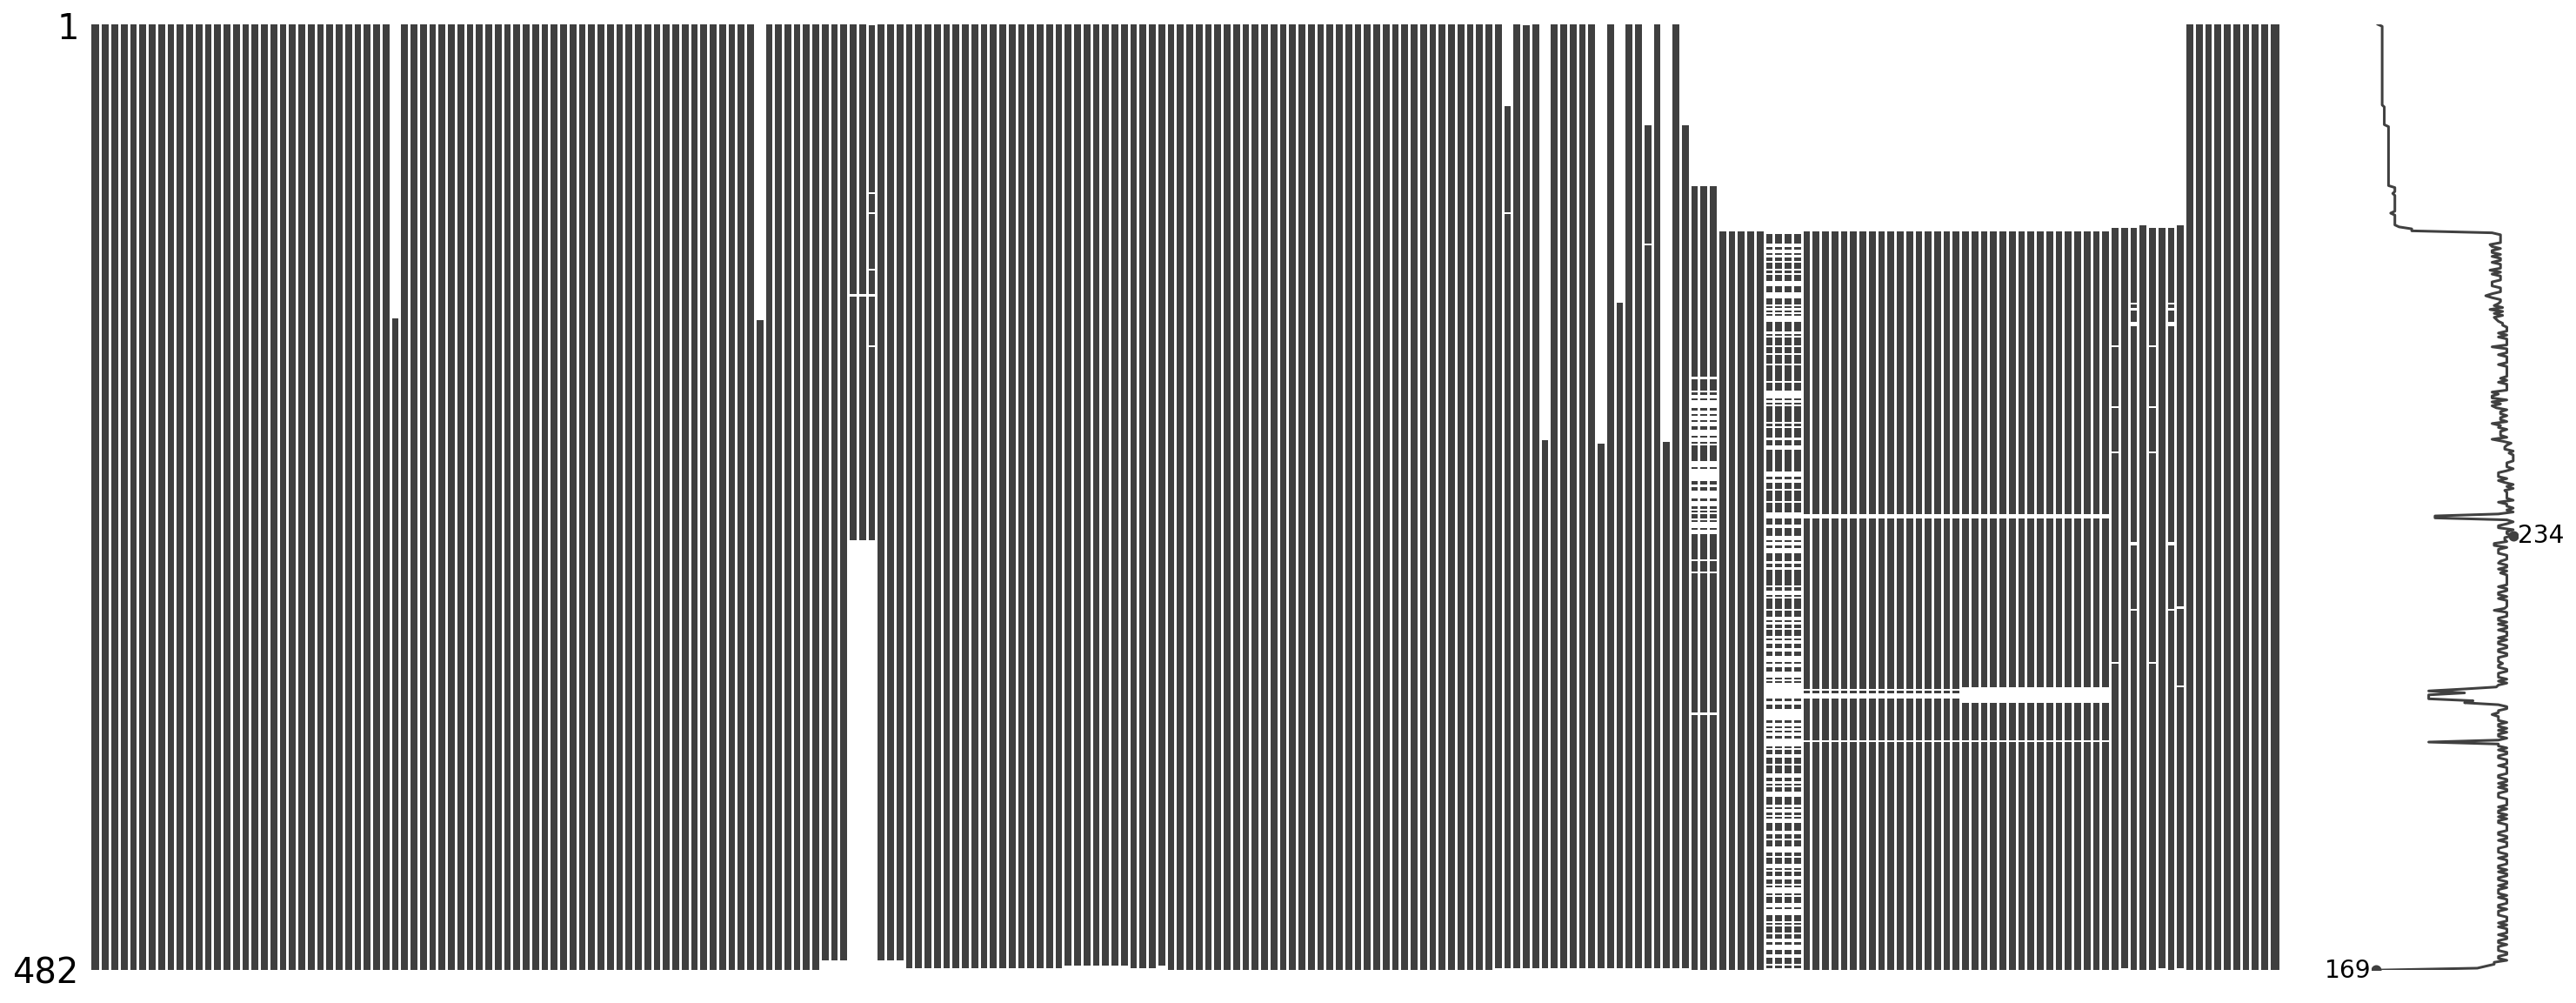

In [15]:
msno.matrix(df_imp)
plt.savefig(FIGSDIR/'03b_missing_data_matrix_dropna.eps')
plt.show()

count    482.000000
mean      17.867220
std       22.913627
min        0.000000
25%        3.000000
50%        7.000000
75%       12.500000
max       65.000000
dtype: float64


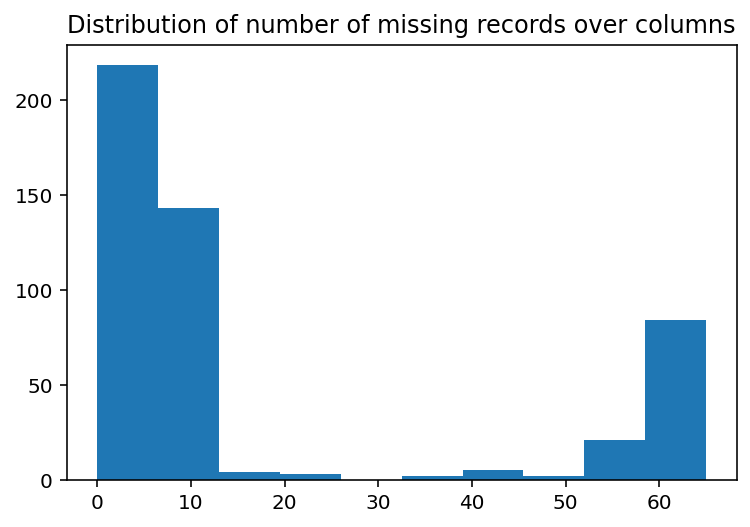

In [16]:
# Analyse distribution of missing values over columns
print(df_imp.isna().sum(axis=1).describe())
df_imp.isna().sum(axis=1).hist(grid=False)
plt.title("Distribution of number of missing records over columns")
plt.savefig(FIGSDIR/'03b_missing_record_dist.eps')
plt.show()

Let's see which features are the ones missing a lot of values (once we get rid of observations with 15+ missing values)

In [17]:
df_imp[df_imp.isna().sum(axis=1) < 15].isna().sum().sort_values(ascending=False).head(30)

city_weather_id                            211
travelling                                 209
at_home                                    209
aw_calls_call_duration_mean                147
aw_calls_call_duration_max                 147
aw_calls_call_duration_std                 147
aw_calls_call_duration_count               147
wol_made_music                             108
wol_studied_anki                           107
wol_added_to_anki                          106
mood_score                                  48
mood_energy                                 48
mood_affect                                 48
sleep_yesterday_ready_score_hrv_balance     45
oura_ready_score_hrv_balance                44
wol_morning_journal                         36
aw_hr_heart_rate_median_morn                 7
aw_hr_heart_rate_std_morn                    7
aw_hr_heart_rate_median_day                  4
aw_hr_heart_rate_std_day                     4
daily_weekday                                3
daily_year   

Let's also look at _where_ the values are missing

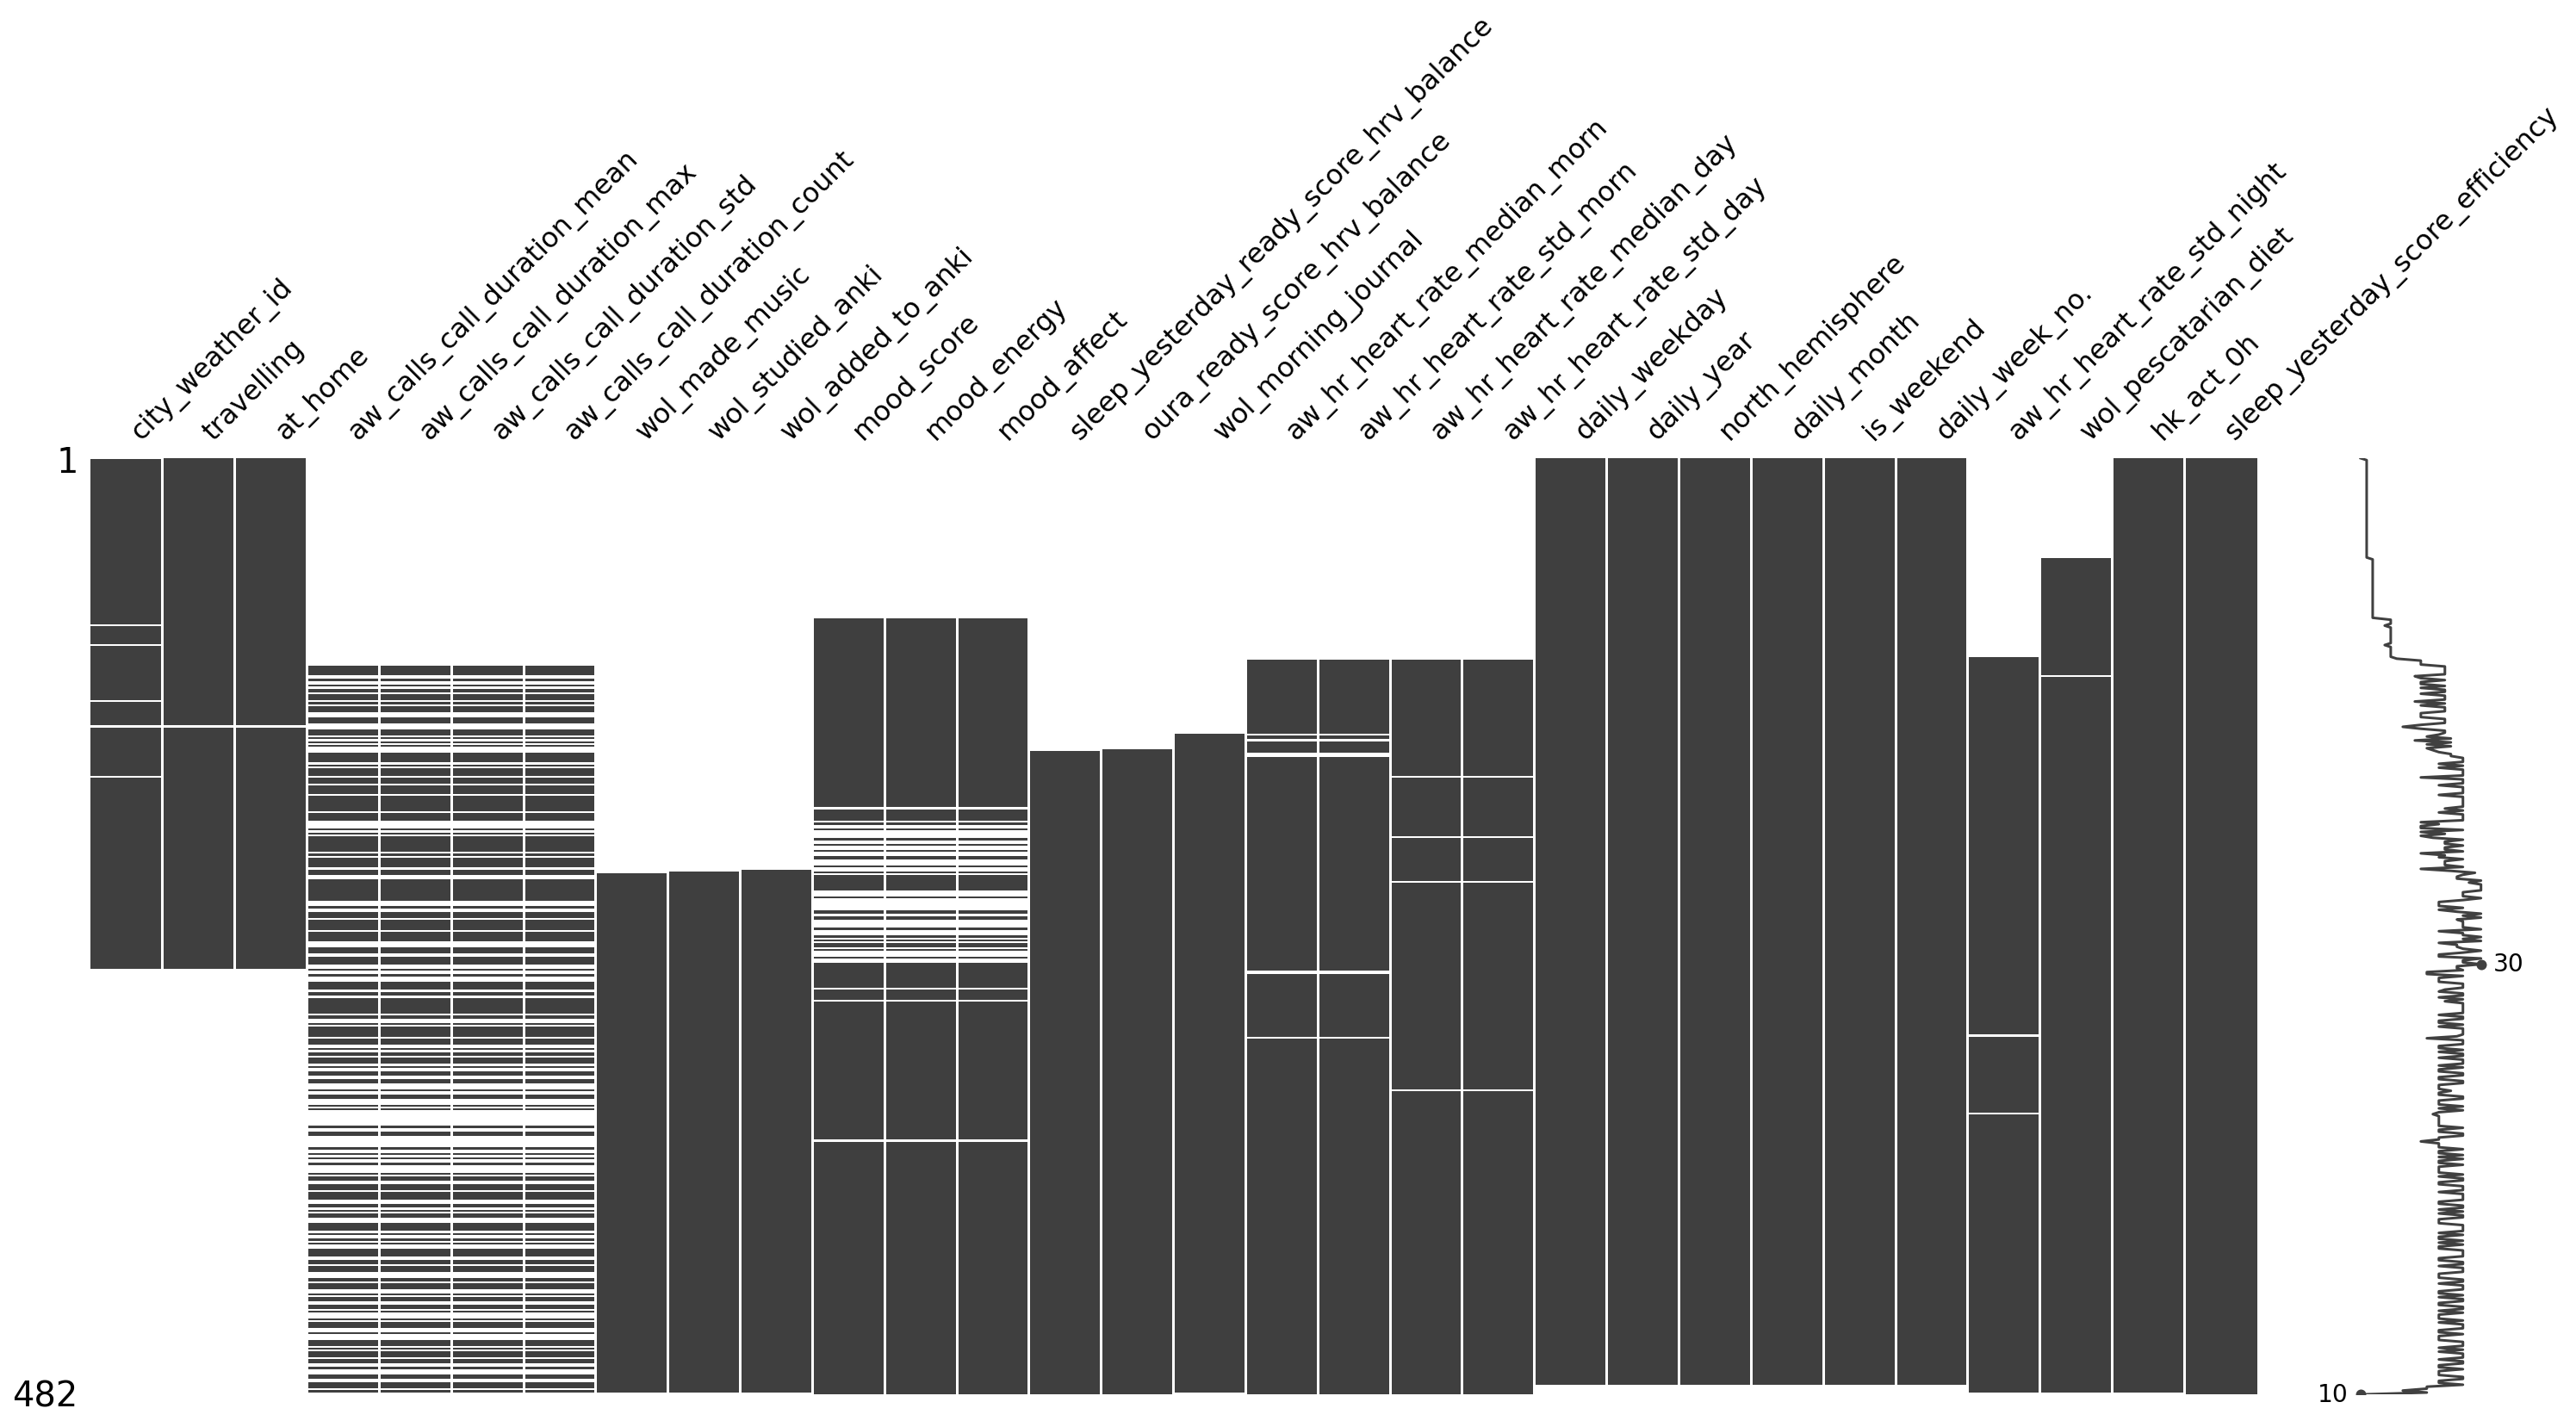

In [18]:
msno.matrix(df_imp[df_imp[df_imp.isna().sum(axis=1) < 15].isna().sum().sort_values(ascending=False).head(30).index])
plt.savefig(FIGSDIR/'03b_missing_data_matrix_worst.eps')
plt.show()

For the habits (`wol_` features), we can (quite safely) assume that I wasn't really doing them before I started logging them — I add them to the app when I want to start getting into them regularly. So we can just fill them with 0 before they existed.

In [ ]:
wol_cols = [c for c in df_imp.columns if 'wol_' in c]
msno.matrix(df_imp[wol_cols], figsize=(4, 3), fontsize=8)
plt.tight_layout()
plt.savefig(FIGSDIR/'03b_missing_data_matrix_wol.eps')
plt.show()

In [ ]:
df_imp[wol_cols] = df_imp[wol_cols].fillna(0.0)
msno.matrix(df_imp[wol_cols], figsize=(4, 3), fontsize=8)
plt.tight_layout()
plt.savefig(FIGSDIR/'03b_missing_data_matrix_wol_filled.eps')
plt.show()

Calls (`aw_call` features) were automatically tracked after a certain date (`AWARE_START`), so any missing values thereafter are probably indicative of no calls having occurred. We can fill these with appropriate null values as we did with caffeine and alcohol.

In [21]:
# we start by getting the index corresponding to AWARE_START (as we no longer have dates)
call_start_index = df_imp[~df_imp['aw_calls_call_duration_mean'].isna()].head(1).index.values[0]
call_start_index

107

In [ ]:
call_cols = [c for c in df_imp.columns if 'aw_call' in c]
msno.matrix(df_imp[df_imp.index > call_start_index][call_cols], figsize=(4, 3), fontsize=8)
plt.savefig(FIGSDIR/'03b_missing_data_matrix_awcall.eps')
plt.show()

In [ ]:
df_imp.loc[df_imp.index > call_start_index, call_cols] = df_imp[df_imp.index > call_start_index][call_cols].fillna({
    'aw_calls_call_duration_mean': -1, 
    'aw_calls_call_duration_max': -1,
    'aw_calls_call_duration_std': -1,
    'aw_calls_call_duration_count': 0.0,
})
msno.matrix(df_imp[df_imp.index > call_start_index][call_cols], figsize=(4, 3), fontsize=8)
plt.savefig(FIGSDIR/'03b_missing_data_matrix_awcall_filled.eps')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


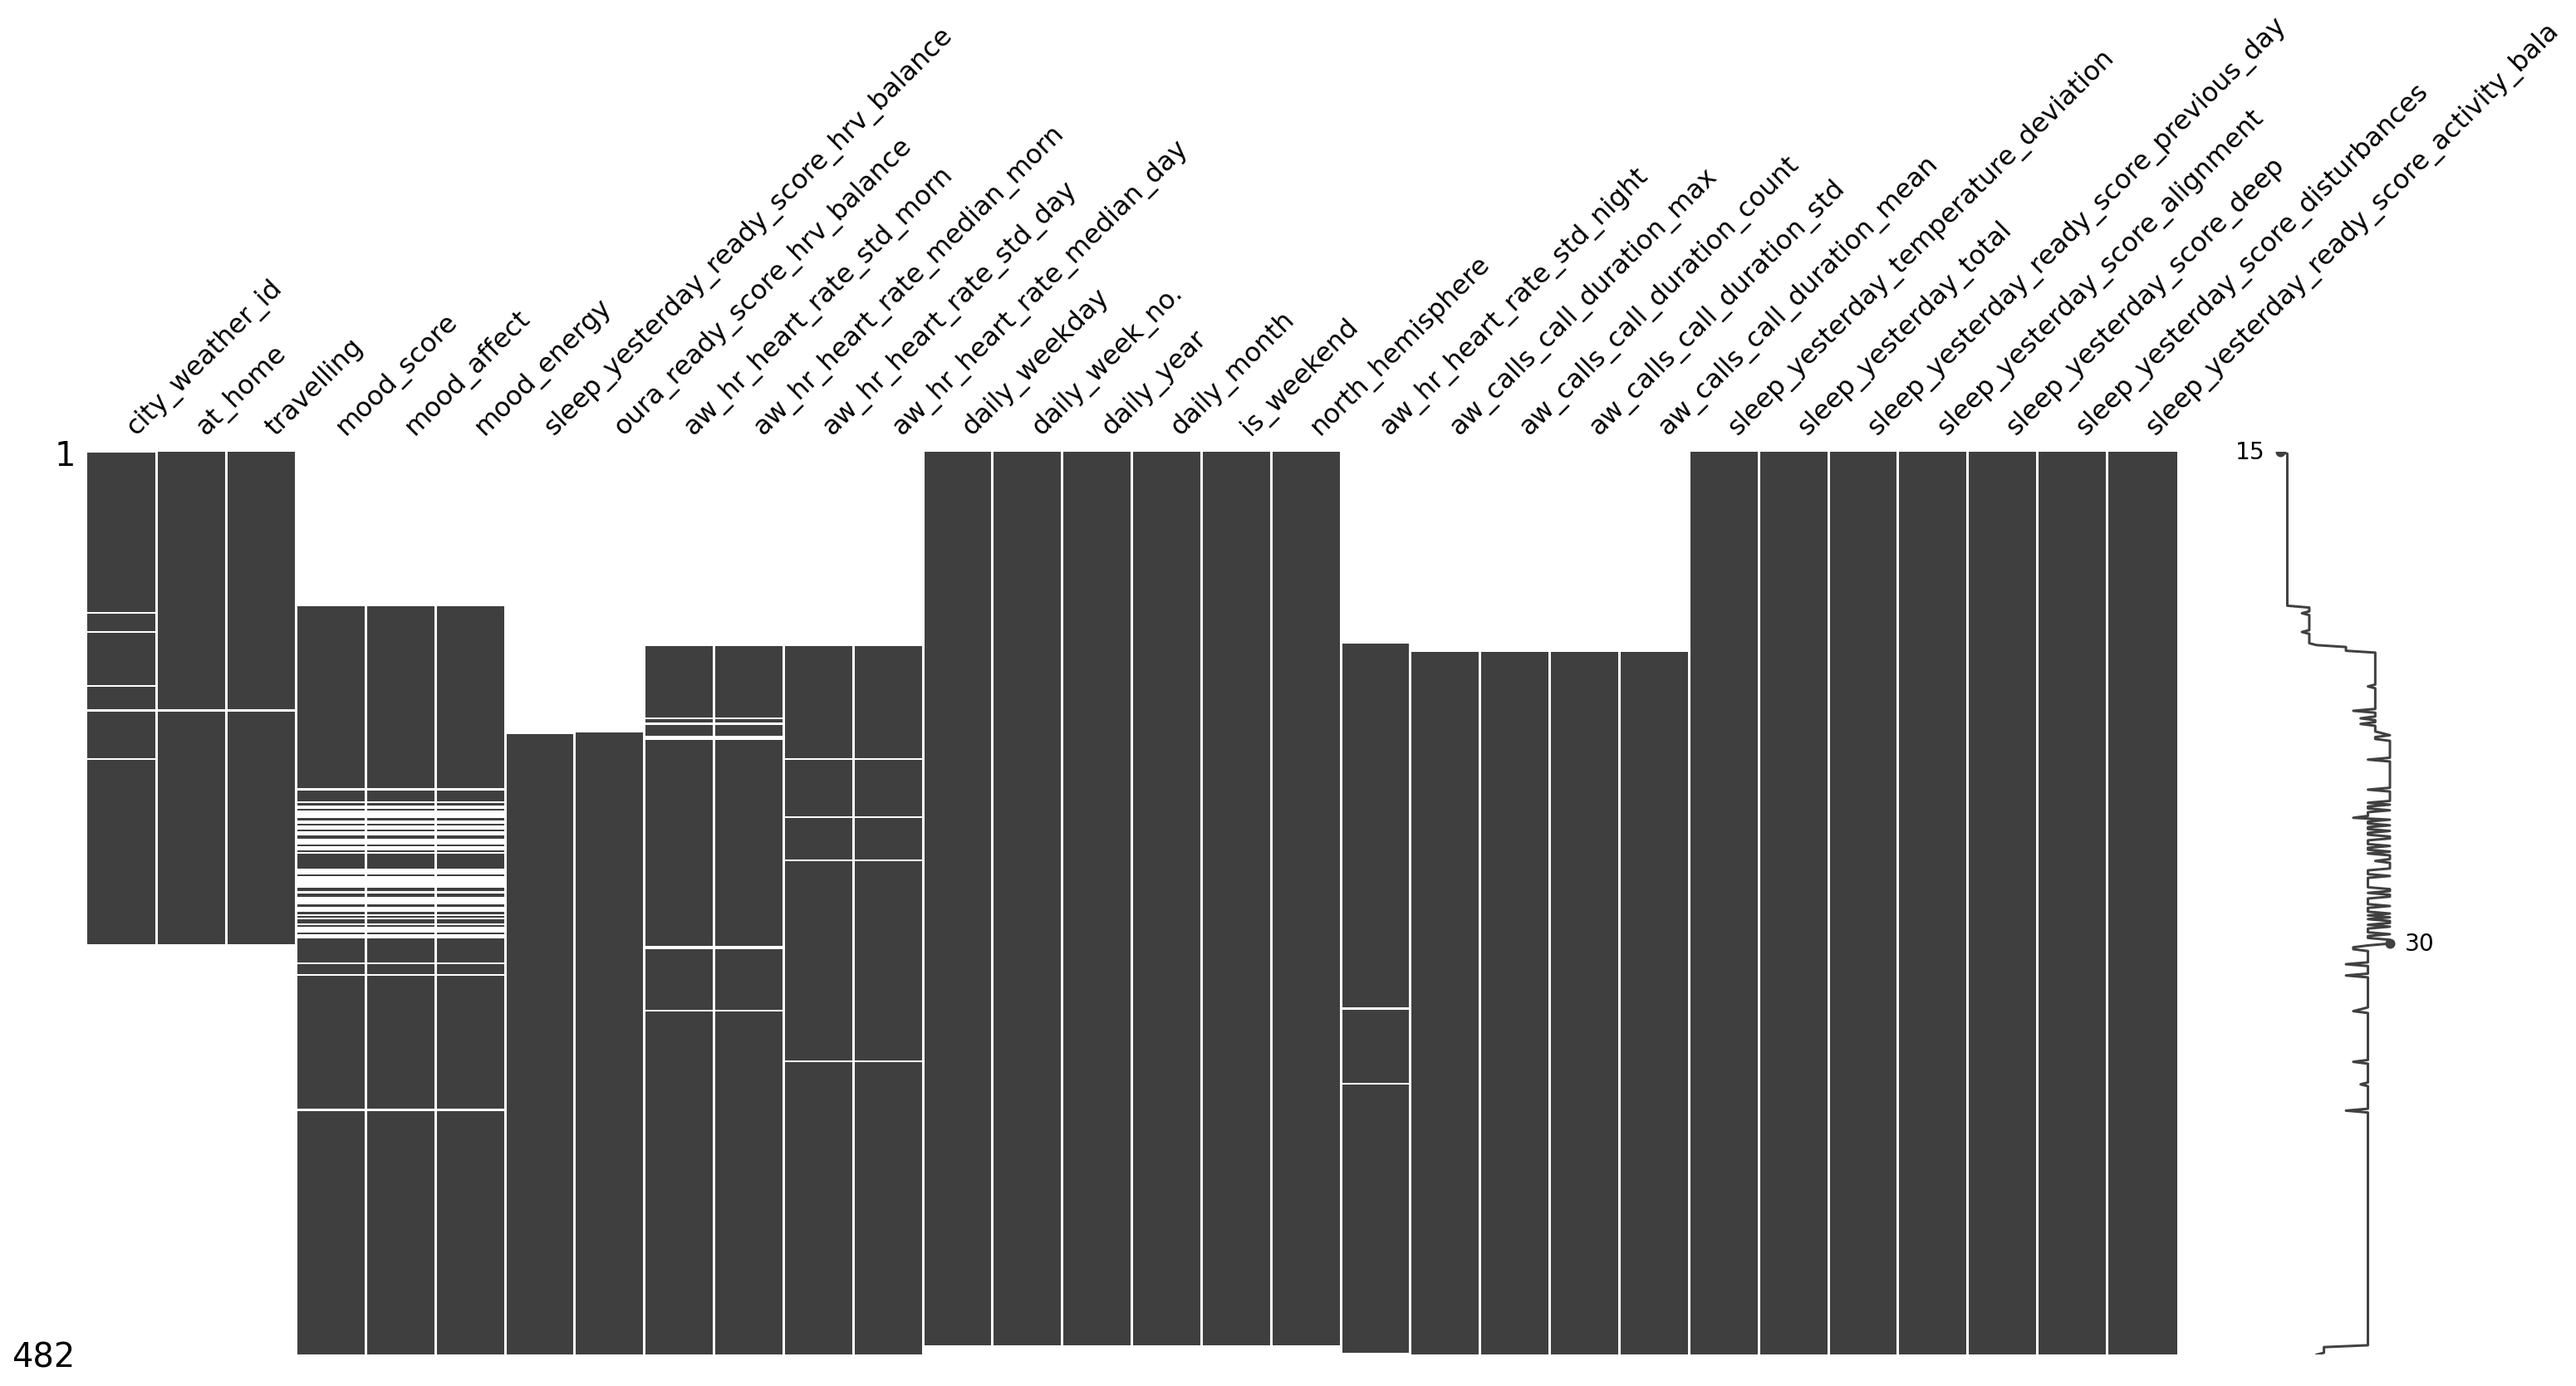

In [24]:
msno.matrix(df_imp[df_imp[df_imp.isna().sum(axis=1) < 15].isna().sum().sort_values(ascending=False).head(30).index])
plt.tight_layout()
plt.savefig(FIGSDIR/'03b_missing_data_matrix_worst_filled.eps')
plt.show()

The data left in `df_imp` (that is, the features with more than 30% of values present) is strongly bi-modal on missing data (by row). We can split it into rows with missing values and rows no missing values -- what we'll call "pure". Let's then label them.

In [25]:
print("0\t", df_imp[df_imp.isna().sum(axis=1) == 0].shape)
print("<15\t", df_imp[df_imp.isna().sum(axis=1) < 15].shape)
print(">=15\t", df_imp[df_imp.isna().sum(axis=1) >= 15].shape)

0	 (61, 234)
<15	 (363, 234)
>=15	 (119, 234)


The "pure" values are no longer well-balanced by the (highly important) hemisphere feature. TODO is this a problem?

In [26]:
df_imp[df_imp.isna().sum(axis=1) == 0].north_hemisphere.value_counts()

0.0    50
1.0    11
Name: north_hemisphere, dtype: int64

In [27]:
df_imp['is_pure'] = 0
df_imp.loc[df_imp.isna().sum(axis=1) == 0, 'is_pure'] = 1
df_imp['is_pure'].value_counts()

0    421
1     61
Name: is_pure, dtype: int64

In [29]:
# Just verifying that pure columns don't have many NaNs
df_imp[df_imp.is_pure == 1].isna().mean().sort_values(ascending=False).sum()

0.0

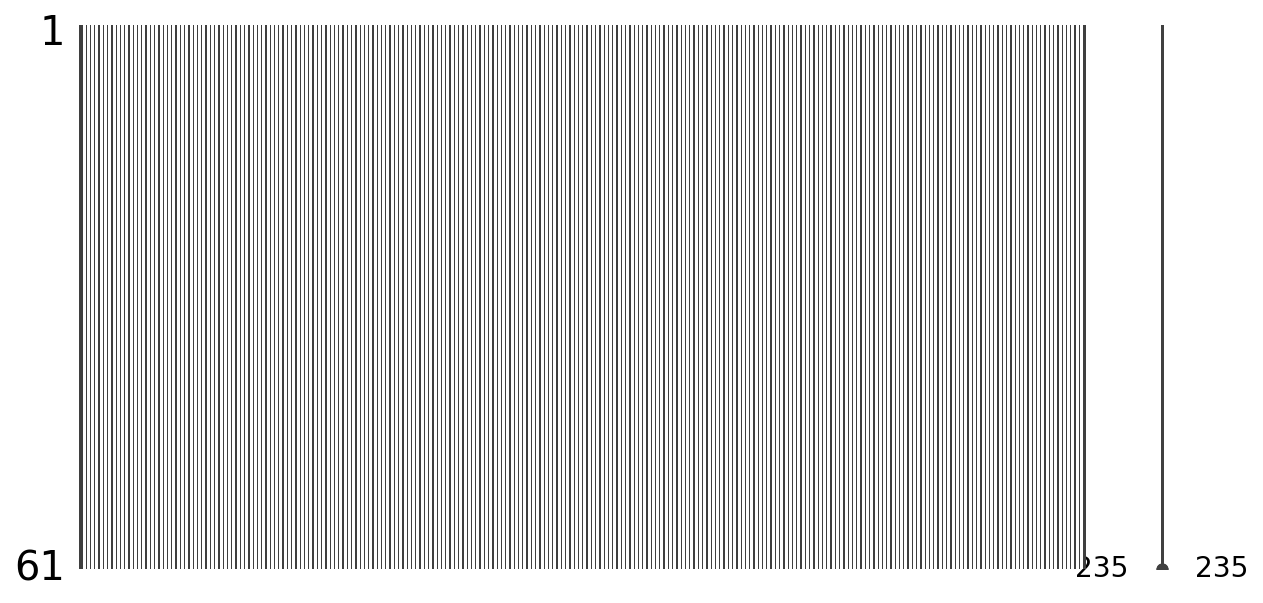

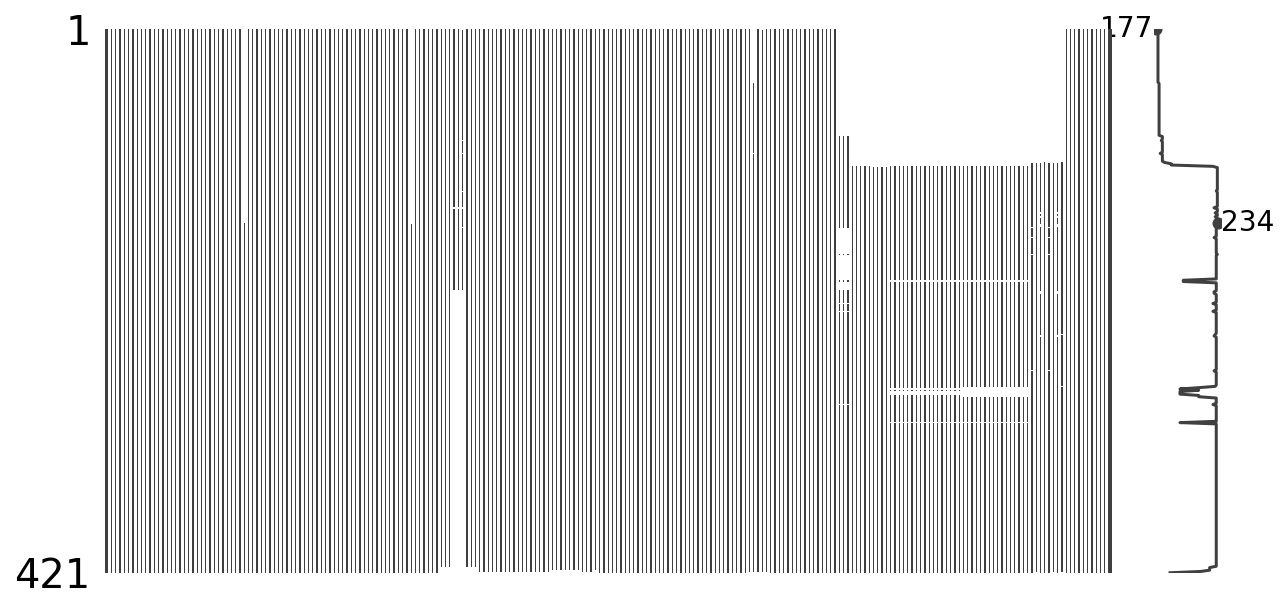

In [30]:
# Compare msno plots for "pure" and "unpure" columns
msno.matrix(df_imp[df_imp.is_pure == 1], figsize=(10, 5))
plt.savefig(FIGSDIR/'03b_missing_data_matrix_pures.eps')
plt.show()
msno.matrix(df_imp[df_imp.is_pure == 0], figsize=(10, 5))
plt.savefig(FIGSDIR/'03b_missing_data_matrix_impures.eps')
plt.show()

In [32]:
# Drop anything that might leak data in later inputation steps (i.e. all Oura features)
df_imp['target'] = df_imp['oura_score']
drop_cols = [c for c in df_imp.columns if 'oura' in c]
drop_cols.extend(['daily_week_no.', 'city_weather_id', 'daily_month', 'daily_year']) # Drop some leaky time-related features
print('dropping:', drop_cols)
df_imp = df_imp.drop(drop_cols, axis=1)

dropping: ['oura_awake', 'oura_bedtime_end_delta', 'oura_bedtime_start_delta', 'oura_breath_average', 'oura_deep', 'oura_duration', 'oura_efficiency', 'oura_hr_average', 'oura_hr_lowest', 'oura_light', 'oura_midpoint_at_delta', 'oura_midpoint_time', 'oura_onset_latency', 'oura_period_id', 'oura_rem', 'oura_restless', 'oura_rmssd', 'oura_score', 'oura_score_alignment', 'oura_score_deep', 'oura_score_disturbances', 'oura_score_efficiency', 'oura_score_latency', 'oura_score_rem', 'oura_score_total', 'oura_temperature_delta', 'oura_temperature_deviation', 'oura_temperature_trend_deviati', 'oura_timezone', 'oura_total', 'oura_ready_score', 'oura_ready_score_activity_bala', 'oura_ready_score_hrv_balance', 'oura_ready_score_previous_day', 'oura_ready_score_previous_nigh', 'oura_ready_score_recovery_inde', 'oura_ready_score_resting_hr', 'oura_ready_score_sleep_balance', 'oura_ready_score_temperature', 'daily_week_no.', 'city_weather_id', 'daily_month', 'daily_year']


In [33]:
df_imp[df_imp.is_pure == 1].shape

(61, 193)

In [34]:
df_imp[df_imp.isna().sum(axis=1) == 0].is_pure.value_counts()

1    61
Name: is_pure, dtype: int64

In [35]:
# Export dataset with tidied "pure" and "unpure" rows to CSV
df_imp.to_csv(DATADIR/'Trainable/pre_markov_with_nans.csv', index=None)

One (unavoidable?) issue with this `is_pure` approach is that the distributions of the target variable differ considerably.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


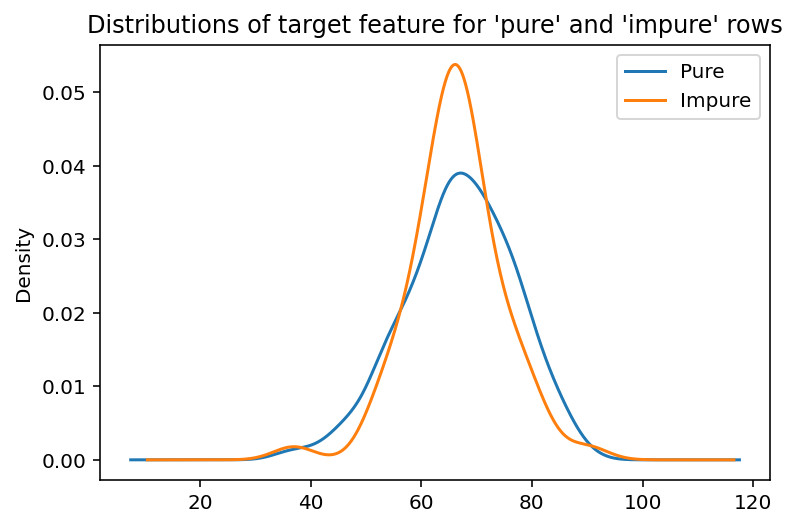

In [36]:
df_imp[df_imp.is_pure == 0].target.plot(kind='kde', label="Pure")
df_imp[df_imp.is_pure == 1].target.plot(kind='kde', label="Impure")
plt.legend()
plt.title("Distributions of target feature for 'pure' and 'impure' rows")
plt.savefig(FIGSDIR/'03b_pure_impure_dist.eps')
plt.show()

In [37]:
# Specify features we DON'T want to impute on or from
dont_impute_cols = [
     'target',
]

In [38]:
# Define subset of dataset to imput on
_df_imp = df_imp.drop(dont_impute_cols, axis=1)

In [39]:
from scipy.spatial.distance import jensenshannon


def js_dists(df1, df2, incl_columns=None, bins=1000, density=True):
    """ Computes Jenson-Shannon distance for each feature in a pair of DataFrames with identical column names.
    """
    
    assert list(df1.columns) == list(df2.columns)
    if incl_columns is None:
        incl_columns = df1.columns
    
    # Generate density histograms for each feature in each DataFrame
    hists1 = [np.histogram(df1[c].dropna(), density=density, bins=bins)[0] for c in incl_columns]
    hists2 = [np.histogram(df2[c].dropna(), density=density, bins=bins)[0] for c in incl_columns]
    
    # Calculate Jensen-Shannon distance over each feature
    dists = [jensenshannon(left, right) for left, right in zip(hists1, hists2)]
    
    return pd.DataFrame({'feature': incl_columns, 'js_dist': dists}).set_index('feature')

impdists = {'method': [], 'dist': []}

## Traditional (univariate) imputation

In [40]:
from sklearn.impute import SimpleImputer

# Create imputers
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

# Apply mean imputations 
df_imp_mean = pd.DataFrame(imp_mean.fit_transform(_df_imp), columns=_df_imp.columns)
dist = js_dists(df_imp_mean, _df_imp).mean().values[0]
impdists['method'].append('Univariate Mean')
impdists['dist'].append(dist)
print('Mean JS dist:', dist)

# Apply median imputations
df_imp_median = pd.DataFrame(imp_median.fit_transform(_df_imp), columns=_df_imp.columns)
dist = js_dists(df_imp_median, _df_imp).mean().values[0]
impdists['method'].append('Univariate Median')
impdists['dist'].append(dist)
print('Median JS dist:', dist)

# Re-attach other columns
df_imp_mean = pd.concat([df_imp_mean, df_imp[dont_impute_cols]], axis=1)
df_imp_median = pd.concat([df_imp_median, df_imp[dont_impute_cols]], axis=1)

Mean JS dist: 0.09225261881327569
Median JS dist: 0.053458586141968724


In [41]:
df_imp_mean.to_csv(DATADIR/'Trainable/pre_markov_univ_imp_mean.csv', index=None)
df_imp_median.to_csv(DATADIR/'Trainable/pre_markov_univ_imp_median.csv', index=None)

## Advanced (multivariate) imputation

In [42]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

MAX_ITERATIONS = 50

# Create imputers
imp = IterativeImputer(max_iter=MAX_ITERATIONS, random_state=0, verbose=1, 
                       initial_strategy='most_frequent', imputation_order='random', 
                       min_value=_df_imp.min().values)

# Apply imputations 
df_imp_iter = pd.DataFrame(imp.fit_transform(_df_imp), columns=_df_imp.columns)
dist = js_dists(df_imp_iter, _df_imp).mean().values[0]
impdists['method'].append('Iterative imputer'); impdists['dist'].append(dist)
print('JS dist:', dist)

# Re-attach other columns
df_imp_iter = pd.concat([df_imp_iter, df_imp[dont_impute_cols]], axis=1)

# Save
df_imp_iter.to_csv(DATADIR/f'Trainable/pre_markov_multi_imp_{MAX_ITERATIONS}it.csv', index=None)

[IterativeImputer] Completing matrix with shape (482, 192)
[IterativeImputer] Change: 3522.3108289638917, scaled tolerance: 49.02 
[IterativeImputer] Change: 1681.8353402197506, scaled tolerance: 49.02 
[IterativeImputer] Change: 482.6381528323021, scaled tolerance: 49.02 
[IterativeImputer] Change: 1897.722060588856, scaled tolerance: 49.02 
[IterativeImputer] Change: 1188.666097404463, scaled tolerance: 49.02 
[IterativeImputer] Change: 994.1982300582526, scaled tolerance: 49.02 
[IterativeImputer] Change: 265.42098499731617, scaled tolerance: 49.02 
[IterativeImputer] Change: 1054.721601978993, scaled tolerance: 49.02 
[IterativeImputer] Change: 833.0957990984151, scaled tolerance: 49.02 
[IterativeImputer] Change: 893.6011045172465, scaled tolerance: 49.02 
[IterativeImputer] Change: 177.4607550451682, scaled tolerance: 49.02 
[IterativeImputer] Change: 786.4373071918146, scaled tolerance: 49.02 
[IterativeImputer] Change: 638.1149935707239, scaled tolerance: 49.02 
[IterativeImput

In [43]:
"""IterativeImputer can also be used for multiple imputations by applying it repeatedly to 
the same dataset with different random seeds when sample_posterior=True.
"""

MAX_ITERATIONS = 5
MICE_SAMPLES = 15

mice_dfs = []
for i in tqdm(range(MICE_SAMPLES), desc='MICE'):
    
    imp = IterativeImputer(max_iter=MAX_ITERATIONS, verbose=0, 
                           initial_strategy='most_frequent', imputation_order='random', 
                           min_value=_df_imp.min().values, sample_posterior=True)

    # Apply imputations 
    _df = pd.DataFrame(imp.fit_transform(_df_imp), columns=_df_imp.columns)
    dist = js_dists(_df, _df_imp).mean().values[0]
    print('JS dist:', dist)

    # Re-attach other columns
    mice_dfs.append(pd.concat([_df, df_imp[dont_impute_cols]], axis=1))

# Stitch all the MICE iterations together
df_imp_mice = pd.concat(mice_dfs)
# Drop duplicate pure rows (which didn't have any nans to beging with)
print(df_imp_mice.shape, df_imp_mice[df_imp_mice.is_pure == 1].shape, df_imp[df_imp.is_pure == 1].shape)
df_imp_mice = df_imp_mice.drop_duplicates(keep='first')
print(df_imp_mice.shape)

# Save
df_imp_mice.to_csv(DATADIR/f'Trainable/pre_markov_mice_{MICE_SAMPLES}.csv', index=None)

# Score
dist = js_dists(df_imp_mice[_df_imp.columns], _df_imp).mean().values[0]
impdists['method'].append(f'Mice {MICE_SAMPLES}'); impdists['dist'].append(dist)
print('JS dist:', dist)

MICE:   7%|▋         | 1/15 [00:55<12:57, 55.56s/it]

JS dist: 0.17334050045348903


MICE:  13%|█▎        | 2/15 [01:50<11:59, 55.34s/it]

JS dist: 0.1625954106134819


MICE:  20%|██        | 3/15 [02:42<10:51, 54.33s/it]

JS dist: 0.1748622329915397


MICE:  27%|██▋       | 4/15 [03:28<09:30, 51.90s/it]

JS dist: 0.17645969118996274


MICE:  33%|███▎      | 5/15 [04:14<08:20, 50.02s/it]

JS dist: 0.17061476912657392


MICE:  40%|████      | 6/15 [04:59<07:16, 48.49s/it]

JS dist: 0.16875940146759427


MICE:  47%|████▋     | 7/15 [05:45<06:21, 47.71s/it]

JS dist: 0.17978060513771113


MICE:  53%|█████▎    | 8/15 [06:31<05:30, 47.20s/it]

JS dist: 0.1601702060780454


MICE:  60%|██████    | 9/15 [07:18<04:42, 47.14s/it]

JS dist: 0.18268183753148412


MICE:  67%|██████▋   | 10/15 [08:04<03:55, 47.04s/it]

JS dist: 0.17818969389359762


MICE:  73%|███████▎  | 11/15 [08:50<03:06, 46.67s/it]

JS dist: 0.17161327606216423


MICE:  80%|████████  | 12/15 [09:36<02:19, 46.51s/it]

JS dist: 0.16210236280358256


MICE:  87%|████████▋ | 13/15 [10:24<01:33, 46.78s/it]

JS dist: 0.16839574171468816


MICE:  93%|█████████▎| 14/15 [11:10<00:46, 46.69s/it]

JS dist: 0.17137102773576862


MICE: 100%|██████████| 15/15 [11:56<00:00, 47.79s/it]

JS dist: 0.1644319321915669
(7230, 193) (915, 193) (61, 193)
(6376, 193)


JS dist: 0.2291725863412923


In [44]:
df_imp_mice.shape, _df_imp.shape

((6376, 193), (482, 192))

In [45]:
df_imp_mice.is_pure.value_counts()

0.0    6315
1.0      61
Name: is_pure, dtype: int64

In [46]:
df_imp.is_pure.value_counts()

0    421
1     61
Name: is_pure, dtype: int64

In [ ]:
# Let's use the awesome fancyimpute libarary to implement some more sophisticated methods
from fancyimpute import KNN, BiScaler, IterativeSVD, MatrixFactorization, SoftImpute

In [48]:
# Nearest neighbour imputations 
print('KNN...')
k = 3
# Impute missing values on specified subset of features
imputed_X = pd.DataFrame(KNN(k=k).fit_transform(_df_imp), columns=_df_imp.columns)
dist = js_dists(imputed_X, _df_imp).mean().values[0]
impdists['method'].append(f'KNN {k}'); impdists['dist'].append(dist)
print('JS dist:', dist)

# Concatenate other features and save to CSV
pd.concat([imputed_X, df_imp[dont_impute_cols]], axis=1).to_csv(DATADIR/f'Trainable/pre_markov_knn_{k}.csv', index=None)

KNN...
Imputing row 1/482 with 56 missing, elapsed time: 0.205
Imputing row 101/482 with 51 missing, elapsed time: 0.346
Imputing row 201/482 with 3 missing, elapsed time: 0.355
Imputing row 301/482 with 2 missing, elapsed time: 0.362
Imputing row 401/482 with 2 missing, elapsed time: 0.375
JS dist: 0.06578678169559964


In [49]:
# Matrix completion by iterative soft thresholding of SVD decompositions.
print('SoftImpute...')
# Impute missing values on specified subset of features
imputed_X = pd.DataFrame(SoftImpute().fit_transform(_df_imp), columns=_df_imp.columns)
dist = js_dists(imputed_X, _df_imp).mean().values[0]
impdists['method'].append('Softimpute'); impdists['dist'].append(dist)
print('JS dist:', dist)

# Concatenate other features and save to CSV
pd.concat([imputed_X, df_imp[dont_impute_cols]], axis=1).to_csv(DATADIR/f'Trainable/pre_markov_softimpute.csv', index=None)

SoftImpute...
[SoftImpute] Max Singular Value of X_init = 1291785.446210
[SoftImpute] Iter 1: observed MAE=52.068477 rank=6
[SoftImpute] Iter 2: observed MAE=51.610029 rank=6
[SoftImpute] Iter 3: observed MAE=51.590286 rank=6
[SoftImpute] Iter 4: observed MAE=51.610260 rank=6
[SoftImpute] Iter 5: observed MAE=51.625637 rank=6
[SoftImpute] Iter 6: observed MAE=51.634790 rank=6
[SoftImpute] Iter 7: observed MAE=51.639823 rank=6
[SoftImpute] Iter 8: observed MAE=51.642526 rank=6
[SoftImpute] Iter 9: observed MAE=51.643959 rank=6
[SoftImpute] Iter 10: observed MAE=51.644712 rank=6
[SoftImpute] Stopped after iteration 10 for lambda=25835.708924
JS dist: 0.1318731802423002


In [50]:
# Matrix completion by iterative low-rank SVD decomposition.
print('IterativeSVD...')
# Impute missing values on specified subset of features
imputed_X = pd.DataFrame(IterativeSVD().fit_transform(_df_imp), columns=_df_imp.columns)
dist = js_dists(imputed_X, _df_imp).mean().values[0]
impdists['method'].append('IterativeSVD'); impdists['dist'].append(dist)
print('JS dist:', dist)

# Concatenate other features and save to CSV
pd.concat([imputed_X, df_imp[dont_impute_cols]], axis=1).to_csv(DATADIR/f'Trainable/pre_markov_iterativesvd.csv', index=None)

IterativeSVD...
[IterativeSVD] Iter 1: observed MAE=153.464024
[IterativeSVD] Iter 2: observed MAE=61.431651
[IterativeSVD] Iter 3: observed MAE=32.740968
[IterativeSVD] Iter 4: observed MAE=5.783790
[IterativeSVD] Iter 5: observed MAE=4.780213
[IterativeSVD] Iter 6: observed MAE=4.816349
[IterativeSVD] Iter 7: observed MAE=4.819698
[IterativeSVD] Iter 8: observed MAE=4.760948
[IterativeSVD] Iter 9: observed MAE=4.738631
[IterativeSVD] Iter 10: observed MAE=4.725834
[IterativeSVD] Iter 11: observed MAE=4.717041
[IterativeSVD] Iter 12: observed MAE=4.710475
[IterativeSVD] Iter 13: observed MAE=4.705314
[IterativeSVD] Iter 14: observed MAE=4.701079
[IterativeSVD] Iter 15: observed MAE=4.697442
[IterativeSVD] Iter 16: observed MAE=4.694303
[IterativeSVD] Iter 17: observed MAE=4.691508
[IterativeSVD] Iter 18: observed MAE=4.688976
[IterativeSVD] Iter 19: observed MAE=4.686697
[IterativeSVD] Iter 20: observed MAE=4.684616
[IterativeSVD] Iter 21: observed MAE=4.682688
[IterativeSVD] Iter 22:

In [51]:
# Direct factorisation of the incomplete matrix into low-rank U and V (with L1 sparsity penalty)
print('MatrixFactorization...')
# Impute missing values on specified subset of features
imputed_X = pd.DataFrame(MatrixFactorization().fit_transform(_df_imp), columns=_df_imp.columns)
dist = js_dists(imputed_X, _df_imp).mean().values[0]
impdists['method'].append('Matrix factorisation'); impdists['dist'].append(dist)
print('JS dist:', dist)
# Concatenate other features and save to CSV
pd.concat([imputed_X, df_imp[dont_impute_cols]], axis=1).to_csv(DATADIR/f'Trainable/pre_markov_matrixfactorization.csv', index=None)

MatrixFactorization...
Train on 77266 samples, validate on 8586 samples
Epoch 1/10000
77266/77266 [==============================] - 0s 6us/step - loss: 1.0864 - val_loss: 1.1222
Epoch 2/10000
77266/77266 [==============================] - 0s 1us/step - loss: 1.0842 - val_loss: 1.1215
Epoch 3/10000
77266/77266 [==============================] - 0s 1us/step - loss: 1.0831 - val_loss: 1.1208
Epoch 4/10000
77266/77266 [==============================] - 0s 1us/step - loss: 1.0820 - val_loss: 1.1201
Epoch 5/10000
77266/77266 [==============================] - 0s 1us/step - loss: 1.0809 - val_loss: 1.1194
Epoch 6/10000
77266/77266 [==============================] - 0s 1us/step - loss: 1.0797 - val_loss: 1.1188
Epoch 7/10000
77266/77266 [==============================] - 0s 1us/step - loss: 1.0786 - val_loss: 1.1181
Epoch 8/10000
77266/77266 [==============================] - 0s 1us/step - loss: 1.0776 - val_loss: 1.1174
Epoch 9/10000
77266/77266 [==============================] - 0s 1us/step

In [53]:
df_dists = pd.DataFrame(impdists)
df_dists.to_csv(DATADIR/'imputation_dists.csv', index=False)
df_dists.sort_values('dist').round(4)

,method,dist
1,Univariate Median,0.0535
4,KNN 3,0.0658
0,Univariate Mean,0.0923
2,Iterative imputer,0.0986
5,Softimpute,0.1319
7,Matrix factorisation,0.1897
6,IterativeSVD,0.2147
3,Mice 15,0.2292


In [ ]:
from tqdm import tqdm

COLS = 4
SAMPLES = 24
rows = SAMPLES // COLS + 1
fig, ax = plt.subplots(rows, COLS, figsize=(16, 16))

dists_mean = js_dists(df_imp_mean, df_imp).T
dists_iter = js_dists(df_imp_iter, df_imp).T

for i, c in tqdm(enumerate(_df_imp.sample(SAMPLES, axis=1).columns), total=SAMPLES):
    row = i // COLS
    col = i % COLS
    try:
        _df_imp[c].plot(kind='kde', label='Original', linestyle='-', linewidth=3, ax=ax[row][col])
        df_imp_mean[c].plot(kind='kde', label=f'Imp. univ. {dists_mean[c][0]:.3f}', linestyle='--', ax=ax[row][col])
        df_imp_iter[c].plot(kind='kde', label=f'Imp. multiv. {dists_iter[c][0]:.3f}', linestyle='--', ax=ax[row][col])
        ax[row][col].set_title(f"'{c}'")
        ax[row][col].set_yticks([]) # Disable y labels
        ax[row][col].legend()
    except Exception as e:
        print('\nError:', c, e)
        
plt.tight_layout()
plt.savefig(FIGSDIR/'03b_imp_vs_orig_overview.png', dpi=600)
plt.show()

In [ ]:
for c in _df_imp.columns:    
    try:
        _df_imp[c].plot(kind='kde', label='Original', linestyle='-', linewidth=3, alpha=0.7)
        df_imp_mean[c].plot(kind='kde', label='Imp. univ.', linestyle='--')
        df_imp_iter[c].plot(kind='kde', label='Imp. multiv.', linestyle='--')
        plt.title(f"'{c}'")
        plt.yticks([]) # Disable y labels
        plt.legend()
        plt.savefig(FIGSDIR/f'imputation/imp_{c}.png', dpi=500)
        plt.show()
    except Exception as e:
        print('\nError:', c, e)